# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [3]:
churn["CHURN_IND"].values.max()

1

In [4]:
churnAnalysis = churn[["ACCOUNT_TENURE", "ACCT_CNT_SERVICES", "AGE", "SERVICE_TENURE", "PLAN_ACCESS_FEE", "PLAN_TENURE", "MONTHS_OF_CONTRACT_REMAINING", "PREV_CONTRACT_DURATION", "MONTHLY_SPEND"]]
churnAnalysis

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,PREV_CONTRACT_DURATION,MONTHLY_SPEND
INDEX,,,,,,,,,
1,46,1,30.0,46,54.54,15,0,24,61.40
2,60,3,55.0,59,54.54,5,0,24,54.54
3,65,1,29.0,65,40.90,15,0,12,2.50
4,31,1,51.0,31,31.81,31,0,24,6.48
5,95,1,31.0,95,54.54,0,0,24,100.22
...,...,...,...,...,...,...,...,...,...
46202,10,1,61.0,9,27.27,7,0,0,27.27
46203,2,1,53.0,2,54.54,2,0,24,54.99
46204,47,1,22.0,47,72.72,7,17,24,72.72


In [5]:
churnAnalysis = churnAnalysis.dropna()

In [6]:
km = KMeans(n_clusters = 2)
km.fit(churnAnalysis)

KMeans(n_clusters=2)

In [7]:
churnAnalysis['cluster'] = km.predict(churnAnalysis)

<ipython-input-7-9e38b1149fb5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churnAnalysis['cluster'] = km.predict(churnAnalysis)


In [8]:
churnAnalysis.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,PREV_CONTRACT_DURATION,MONTHLY_SPEND,cluster
INDEX,,,,,,,,,,
1,46,1,30.0,46,54.54,15,0,24,61.40,0
2,60,3,55.0,59,54.54,5,0,24,54.54,0
3,65,1,29.0,65,40.90,15,0,12,2.50,0
4,31,1,51.0,31,31.81,31,0,24,6.48,0
5,95,1,31.0,95,54.54,0,0,24,100.22,0


In [9]:
churnAnalysis.groupby('cluster').mean()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,PREV_CONTRACT_DURATION,MONTHLY_SPEND
cluster,,,,,,,,,
0,47.200177,1.558644,41.895711,52.029450,50.260050,11.024853,7.788785,15.462335,59.114731
1,28.738255,1.498780,35.086333,28.641855,65.750894,8.578096,14.068334,12.519829,285.017001


<AxesSubplot:ylabel='cluster'>

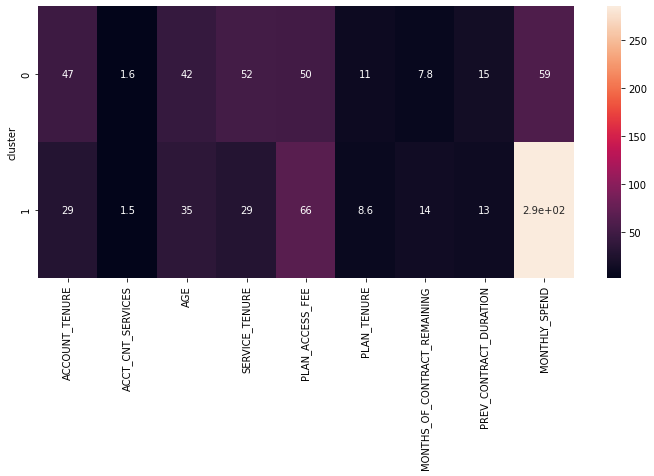

In [10]:
plt.figure(figsize=(12,5))
sns.heatmap(churnAnalysis.groupby('cluster').mean(), annot=True)

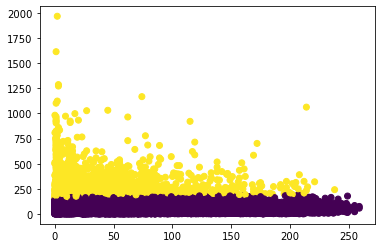

In [11]:
plt.scatter(churnAnalysis['SERVICE_TENURE'], churnAnalysis['MONTHLY_SPEND'], c=churnAnalysis['cluster'])

In [12]:
churn = churn.dropna()

In [13]:
churn['cluster'] = churnAnalysis['cluster']

In [14]:
churn

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH,cluster
INDEX,,,,,,,,,,,,,,,,,,,,,
8153,18301,15,1,66.0,CONSUMER,15,31.81,NON BYO,15,9,...,0,APPLE,0,74.17,COUNTRY,WA,0.0,0.0,0.0,0
8155,18304,49,2,55.0,CONSUMER,49,45.44,NON BYO,29,0,...,24,SAMSUNG,0,89.60,METRO,NSW,0.0,0.0,0.0,0
8159,18312,71,2,34.0,CONSUMER,51,72.72,NON BYO,29,0,...,24,SAMSUNG,0,161.12,COUNTRY,NSW,0.0,0.0,0.0,0
8169,18324,9,1,27.0,SMALL BUSINESS,9,72.72,NON BYO,9,15,...,24,SAMSUNG,0,63.62,METRO,VIC,0.0,0.0,0.0,0
8172,18328,46,1,34.0,CONSUMER,46,72.72,NON BYO,7,17,...,24,APPLE,0,84.53,METRO,VIC,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46201,79490,46,4,51.0,CONSUMER,46,8.18,NON BYO,5,0,...,12,GOOGLE,0,8.18,COUNTRY,NSW,0.0,0.0,0.0,0
46202,79494,10,1,61.0,CONSUMER,9,27.27,BYO,7,0,...,0,OTHER,0,27.27,COUNTRY,VIC,0.0,1.0,0.0,0
46204,79496,47,1,22.0,CONSUMER,47,72.72,NON BYO,7,17,...,24,APPLE,0,72.72,COUNTRY,NSW,0.0,0.0,0.0,0


In [16]:
churn.corr()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH,cluster
CUST_ID,1.000000,0.002340,0.002574,0.008145,0.001180,-0.006300,0.008920,-0.010885,-0.002802,0.003189,NaN,0.007377,-0.001360,-0.002920,-0.008946,0.005074
ACCOUNT_TENURE,0.002340,1.000000,0.203876,0.228927,0.785748,-0.082719,0.198149,-0.134346,0.169450,0.513201,NaN,-0.057773,0.027119,0.057276,0.021792,-0.034976
ACCT_CNT_SERVICES,0.002574,0.203876,1.000000,0.158722,0.073938,-0.007027,-0.019048,-0.004110,0.008702,0.032735,NaN,-0.021027,-0.021703,0.100096,-0.009348,-0.008057
AGE,0.008145,0.228927,0.158722,1.000000,0.236311,-0.378904,0.072699,-0.222861,-0.165191,-0.020187,NaN,-0.265816,-0.044429,0.434718,-0.046446,-0.064216
SERVICE_TENURE,0.001180,0.785748,0.073938,0.236311,1.000000,-0.082896,0.177763,-0.136382,0.120820,0.412735,NaN,-0.061484,0.026324,0.050852,0.016902,-0.031715
PLAN_ACCESS_FEE,-0.006300,-0.082719,-0.007027,-0.378904,-0.082896,1.000000,-0.102997,0.503366,0.397494,0.160218,NaN,0.551365,-0.031203,-0.124343,-0.014458,0.153089
PLAN_TENURE,0.008920,0.198149,-0.019048,0.072699,0.177763,-0.102997,1.000000,-0.438847,0.066858,0.109616,NaN,-0.028220,0.092105,-0.011172,0.066236,-0.020335
MONTHS_OF_CONTRACT_REMAINING,-0.010885,-0.134346,-0.004110,-0.222861,-0.136382,0.503366,-0.438847,1.000000,0.482434,0.082085,NaN,0.270927,-0.099225,-0.013939,-0.067899,0.053821
LAST_FX_CONTRACT_DURATION,-0.002802,0.169450,0.008702,-0.165191,0.120820,0.397494,0.066858,0.482434,1.000000,0.510539,NaN,0.248200,0.001324,-0.022215,0.011848,0.044527
PREV_CONTRACT_DURATION,0.003189,0.513201,0.032735,-0.020187,0.412735,0.160218,0.109616,0.082085,0.510539,1.000000,NaN,0.096054,0.010125,0.008188,0.009172,0.009119
